랭체인에서의 도구(툴) 활용 방법
- 사용할 수 있는 도구들을 LLM에 binding
- llm with tools를 호출할 때, 단순히 쿼리만이 아닌 message list를 전달
- 호출 할 때 나오는 AiMessage의 tool calls를 가지고 도구에게 직접 invoking
- 이후 발생하는 tool_message를 다시 message list에 추가
- 이들을 바탕으로 llm with tools에 invoke 

LangGraph에서 도구(툴) 활용 방법
- 워크플로우를 직접 선언하지 않고, 사용가능한 도구들을 전달하게 되면 에이전트가 적합한 도구를 직접 판단해서 사용

In [2]:
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')

small_llm = ChatOpenAI(model='gpt-4o-mini')


In [4]:
from langchain_core.tools import tool

@tool
def add(a: int, b: int) -> int:
    """숫자 a와 b를 더합니다."""
    return a + b

@tool
def multiply(a: int, b: int) -> int:
    """숫자 a와 b를 곱합니다."""
    return a * b

In [5]:
from langgraph.prebuilt import ToolNode

tool_list = [add, multiply]
llm_with_tools = small_llm.bind_tools(tool_list)
tool_node = ToolNode(tool_list)

in tool_node.py
- Important:
    - The state MUST contain a list of messages.
    - The last message MUST be an `AIMessage`.
     - The `AIMessage` MUST have `tool_calls` populated.

In [6]:
ai_message = llm_with_tools.invoke("3 더하기 5는 몇일까요?")

In [ ]:
ai_message
# 'tool_calls'

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_eFksOrJTY6O1MmugjikO6qA2', 'function': {'arguments': '{"a":3,"b":5}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 86, 'total_tokens': 103, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_29330a9688', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-8608b534-6dd7-441f-adbc-0ed77feae090-0', tool_calls=[{'name': 'add', 'args': {'a': 3, 'b': 5}, 'id': 'call_eFksOrJTY6O1MmugjikO6qA2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 86, 'output_tokens': 17, 'total_tokens': 103, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [ ]:
tool_node.invoke({'messages':[ai_message]})
'''
{'messages':[ai_message]}에서, 지금 'message' state를 갖는데, 얘는 list[AnyMessage]
+ list[AnyMessage]가 지금은 하나밖에 없지만 마지막이, ai_message
그리고 tool_calls 또한 가짐
위에서 tool_node.py의 요구사항을 만족
'''

{'messages': [ToolMessage(content='8', name='add', tool_call_id='call_eFksOrJTY6O1MmugjikO6qA2')]}

In [9]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

<img src="/Users/seonghoe/인프런_랭그래프/lecture./langgraph/툴_도식화.png">

In [ ]:
def agent(state: MessagesState) -> MessagesState:
    
    '''
    에이전트 함수는 주어진 상태에서 메시지를 가져와
    LLM과 도구를 사용하여 응답 메시지를 생성합니다.

    Args:
        state (MessagesState): 메시지 상태를 포함하는 state.

    Returns:
        MessagesState: 응답 메시지를 포함하는 새로운 state.
    '''

    messages = state['messages']    #1  메세지 추출
    response = llm_with_tools.invoke(messages)  #2 LLM & 도구 → 메세치 처리 및 응답 생성
    return {'messages': [response]} #3 새로운 응답 메세지 반환

에이전트 실행 루프
- agent 로직은 State 안의 messages만 봄
- agent에서 호출한 다음, should_continue로 와서 AiMessage를 건네 받음
- AiMessage = response = llm_with_tools에 invoke의 결과
- 여기서, tool_calls의 유무로부터 도구 호출 여부가 달라짐

In [ ]:
def should_continue(state: MessagesState):
    messages = state['messages']    #1 메세지 추출
    last_ai_message = messages[-1]  #2 AiMessage 가져와서 
    if last_ai_message.tool_calls:  
        return 'tools'  #3 도구 호출 포함 여부로부터, 'tools' || 'END' 반환
    return 'end'

In [ ]:
graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node) 

In [13]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges(
    'agent',
    should_continue,
    {
        'tools': 'tools',
        'end': END
    }
)
graph_builder.add_edge('tools', 'agent')

In [14]:
graph = graph_builder.compile()

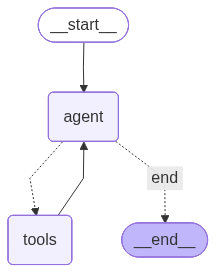

In [15]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

invoke & stream 차이점
- invoke는 LangChain에서 가장 기본적인 메서드로, 동기적으로 언어 모델에 요청을 보내고 결과를 반환 (동기적 요청 처리)
- 요청을 보낸 후, 결과를 받을 때까지 코드가 멈추는 동기 방식으로 동작
- stream은 동기적으로 언어 모델의 응답을 스트리밍 방식으로 처리, 모델이 전체 응답을 완료하기 전에 부분적으로 응답을 받을 수 있는 방법을 제공
- 큰 응답을 처리할 때 유용

In [22]:
from langchain_core.messages import HumanMessage

for chunk in graph.stream({'messages': [HumanMessage('3에다 5를 더하고 거기에 8을 곱하면?')]}, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

3에다 5를 더하고 거기에 8을 곱하면?
================================== Ai Message ==================================
Tool Calls:
  add (call_o3JChO4bjnUJnI3MlrUtEhoW)
 Call ID: call_o3JChO4bjnUJnI3MlrUtEhoW
  Args:
    a: 3
    b: 5
  multiply (call_FEBT0SkCQdPFPNlgxVzW67ph)
 Call ID: call_FEBT0SkCQdPFPNlgxVzW67ph
  Args:
    a: 5
    b: 8
================================= Tool Message =================================
Name: multiply

40
================================== Ai Message ==================================
Tool Calls:
  multiply (call_wcIT0sntteYi5JBreATf2ZFz)
 Call ID: call_wcIT0sntteYi5JBreATf2ZFz
  Args:
    a: 8
    b: 8
================================= Tool Message =================================
Name: multiply

64
================================== Ai Message ==================================

3에 5를 더하면 8이고, 그 결과에 8을 곱하면 64입니다.
